In [3]:
import pandas as pd

In [4]:
data_dir = './data/trial2/'

In [5]:
df = pd.read_csv(data_dir+'driving_log.csv', names=['center_cam', 'left_cam', 'right_cam', 'steering', 'throttle', 'brake', 'speed'])

In [6]:
df.head()

,center_cam,left_cam,right_cam,steering,throttle,brake,speed
0,D:\Documents\Udacity\Self-Driving Car Engineer...,D:\Documents\Udacity\Self-Driving Car Engineer...,D:\Documents\Udacity\Self-Driving Car Engineer...,0.0,0.0,0,0.000011
1,D:\Documents\Udacity\Self-Driving Car Engineer...,D:\Documents\Udacity\Self-Driving Car Engineer...,D:\Documents\Udacity\Self-Driving Car Engineer...,0.0,0.0,0,0.000003
2,D:\Documents\Udacity\Self-Driving Car Engineer...,D:\Documents\Udacity\Self-Driving Car Engineer...,D:\Documents\Udacity\Self-Driving Car Engineer...,0.0,0.0,0,0.000013
3,D:\Documents\Udacity\Self-Driving Car Engineer...,D:\Documents\Udacity\Self-Driving Car Engineer...,D:\Documents\Udacity\Self-Driving Car Engineer...,0.0,0.0,0,0.000015
4,D:\Documents\Udacity\Self-Driving Car Engineer...,D:\Documents\Udacity\Self-Driving Car Engineer...,D:\Documents\Udacity\Self-Driving Car Engineer...,0.0,0.0,0,0.000011


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4216 entries, 0 to 4215
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   center_cam  4216 non-null   object 
 1   left_cam    4216 non-null   object 
 2   right_cam   4216 non-null   object 
 3   steering    4216 non-null   float64
 4   throttle    4216 non-null   float64
 5   brake       4216 non-null   int64  
 6   speed       4216 non-null   float64
dtypes: float64(3), int64(1), object(3)
memory usage: 230.7+ KB


In [8]:
df_clean = df.copy()

In [9]:
df_clean.iloc[:,0:3] = df_clean.iloc[:,0:3].apply(lambda x: data_dir + 'IMG/' + x.str.split('\\').str[-1])

In [10]:
df_clean.head()

,center_cam,left_cam,right_cam,steering,throttle,brake,speed
0,./data/trial2/IMG/center_2021_01_04_23_40_09_6...,./data/trial2/IMG/left_2021_01_04_23_40_09_690...,./data/trial2/IMG/right_2021_01_04_23_40_09_69...,0.0,0.0,0,0.000011
1,./data/trial2/IMG/center_2021_01_04_23_40_09_7...,./data/trial2/IMG/left_2021_01_04_23_40_09_761...,./data/trial2/IMG/right_2021_01_04_23_40_09_76...,0.0,0.0,0,0.000003
2,./data/trial2/IMG/center_2021_01_04_23_40_09_8...,./data/trial2/IMG/left_2021_01_04_23_40_09_828...,./data/trial2/IMG/right_2021_01_04_23_40_09_82...,0.0,0.0,0,0.000013
3,./data/trial2/IMG/center_2021_01_04_23_40_09_8...,./data/trial2/IMG/left_2021_01_04_23_40_09_899...,./data/trial2/IMG/right_2021_01_04_23_40_09_89...,0.0,0.0,0,0.000015
4,./data/trial2/IMG/center_2021_01_04_23_40_09_9...,./data/trial2/IMG/left_2021_01_04_23_40_09_968...,./data/trial2/IMG/right_2021_01_04_23_40_09_96...,0.0,0.0,0,0.000011


In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [12]:
images = []
measurements = []

In [13]:
df_clean['center_cam'].apply(lambda x: images.append(mpimg.imread(x)));
df_clean['steering'].apply(lambda x: measurements.append(x));

In [14]:
import numpy as np

In [15]:
X_train = np.array(images)
y_train = np.array(measurements)

# Training

In [16]:
import tensorflow as tf

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Lambda, Flatten, Dense, Conv2D, MaxPool2D, Dropout, Cropping2D  

In [57]:
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

In [19]:
X_train.shape

(4216, 160, 320, 3)

In [18]:
# model = Sequential()
# model.add(Flatten(input_shape=(160,320,3)))
# model.add(Dense(1))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [20]:
import cv2

In [21]:
modified_images = []

In [22]:
scale_percent = 80 # percent of original size
width = int(X_train[0].shape[1] * scale_percent / 100)
height = int(X_train[0].shape[0] * scale_percent / 100)
dim = (width, height)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
for image in X_train:
    normalized = image.copy()
    normalized[:,:,0] = clahe.apply(normalized[:,:,0])
    normalized[:,:,1] = clahe.apply(normalized[:,:,1])
    normalized[:,:,2] = clahe.apply(normalized[:,:,2])
    grayscale = cv2.cvtColor(normalized, cv2.COLOR_RGB2GRAY)
    downscaled = cv2.resize(grayscale, dim, interpolation=cv2.INTER_AREA)
    modified_images.append(downscaled)
# plt.imshow(cv2.resize(X_train[0], dim, interpolation=cv2.INTER_AREA))

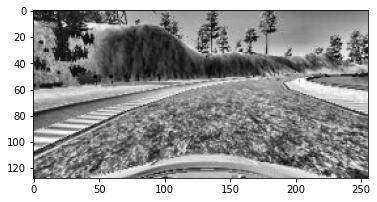

In [23]:
plt.imshow(cv2.flip(modified_images[-1],1), cmap='gray')

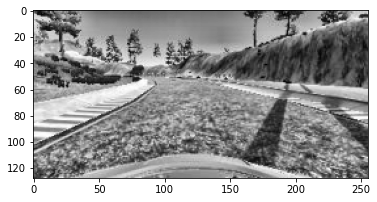

In [25]:
plt.imshow(modified_images[100], cmap='gray')

In [26]:
X_train_modified = np.array(modified_images)
# Adding a dimension for Keras processing purposes
X_train_modified = np.expand_dims(X_train_modified, 3)

In [54]:
tf.keras.backend.clear_session()

In [55]:
model = Sequential()
# Input Layer
model.add(Lambda(lambda x: x/255.0 -0.5, input_shape=(height, width, 1)))
model.add(Cropping2D(cropping=((40,5),(0,0))))
# model.add(Lambda(lambda x: x/255.0 -0.5, input_shape=(160,320,1)))
# Convolution 1
model.add(Conv2D(24, (5,5), strides=(2,2), activation='relu'))
# model.add(MaxPool2D(strides=(1,1)))
# Convolution 2
model.add(Conv2D(36, (5,5), strides=(2,2), activation='relu'))
# model.add(MaxPool2D(strides=(1,1)))
# Convolution 3
model.add(Conv2D(48, (5,5), strides=(2,2), activation='relu'))
# model.add(MaxPool2D(strides=(1,1)))
# Convolution 4
model.add(Conv2D(64, (3,3), activation='relu'))
# Convolution 5
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D(strides=(1,1)))
# Flatten and Dropout
model.add(Flatten())
model.add(Dropout(0.25))
# Fully Connected 1
model.add(Dense(120, activation='relu'))
# Fully Connected 2 with Dropout
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
# Output
model.add(Dense(1));

In [44]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_4 (Lambda)            (None, 128, 256, 1)       0         
_________________________________________________________________
cropping2d_4 (Cropping2D)    (None, 83, 256, 1)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 40, 126, 24)       624       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 18, 61, 36)        21636     
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 7, 29, 48)         43248     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 5, 27, 64)         27712     
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 3, 25, 64)        

In [26]:
# model.compile(loss='mse', optimizer='adam')
# history = model.fit(X_train_modified, y_train, epochs=1, batch_size=256, validation_split=0.2, shuffle=True)

In [52]:
# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs\\fit\\"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [53]:
stopper = EarlyStopping(monitor='val_acc', min_delta=0.0003, patience=5)

In [59]:
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_modified, y_train, epochs=30, batch_size=256, validation_split=0.2, shuffle=True, callbacks=[tensorboard_callback, stopper])

Train on 3372 samples, validate on 844 samples
Epoch 1/30
3372/3372 [==============================] - 4s 1ms/sample - loss: 0.0062 - acc: 0.0629 - val_loss: 0.0049 - val_acc: 0.0118
Epoch 2/30
3372/3372 [==============================] - 4s 1ms/sample - loss: 0.0055 - acc: 0.0629 - val_loss: 0.0042 - val_acc: 0.0118
Epoch 3/30
3372/3372 [==============================] - 4s 1ms/sample - loss: 0.0048 - acc: 0.0629 - val_loss: 0.0031 - val_acc: 0.0118
Epoch 4/30
3372/3372 [==============================] - 4s 1ms/sample - loss: 0.0039 - acc: 0.0629 - val_loss: 0.0019 - val_acc: 0.0118
Epoch 5/30
3372/3372 [==============================] - 4s 1ms/sample - loss: 0.0033 - acc: 0.0629 - val_loss: 0.0015 - val_acc: 0.0118
Epoch 6/30
3372/3372 [==============================] - 4s 1ms/sample - loss: 0.0030 - acc: 0.0629 - val_loss: 0.0017 - val_acc: 0.0118


In [29]:
# model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
# history = model.fit(X_train_modified, y_train, epochs=100, batch_size=200, validation_split=0.2, shuffle=True, callbacks=[tensorboard_callback, stopper])

Train on 3372 samples, validate on 844 samples
Epoch 1/100
3372/3372 [==============================] - 9s 3ms/sample - loss: 0.6001 - acc: 0.0590 - val_loss: 0.0055 - val_acc: 0.0118
Epoch 2/100
3372/3372 [==============================] - 9s 3ms/sample - loss: 0.0057 - acc: 0.0629 - val_loss: 0.0035 - val_acc: 0.0118
Epoch 3/100
3372/3372 [==============================] - 9s 3ms/sample - loss: 0.0047 - acc: 0.0629 - val_loss: 0.0026 - val_acc: 0.0118
Epoch 4/100
3372/3372 [==============================] - 9s 3ms/sample - loss: 0.0039 - acc: 0.0629 - val_loss: 0.0019 - val_acc: 0.0118
Epoch 5/100
3372/3372 [==============================] - 9s 3ms/sample - loss: 0.0031 - acc: 0.0629 - val_loss: 0.0014 - val_acc: 0.0118
Epoch 6/100
3372/3372 [==============================] - 9s 3ms/sample - loss: 0.0027 - acc: 0.0629 - val_loss: 0.0021 - val_acc: 0.0118


In [60]:
model.save('model.h5')

In [31]:
# from tensorflow.keras.models import load_model

In [32]:
# model = load_model('model.h5')

In [33]:
model.predict(np.expand_dims(X_train_modified[100], axis=0))

array([[-0.10582539]], dtype=float32)

In [34]:
# %run drive.py model.h5